In [28]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.api import VAR
from scipy.optimize import minimize
from scipy.stats import norm, t
import scipy.stats as stats
import warnings
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings("ignore")
import seaborn as sns
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
from statsmodels.stats.diagnostic import acorr_ljungbox


[                       0%                       ]

[*********************100%***********************]  3 of 3 completed


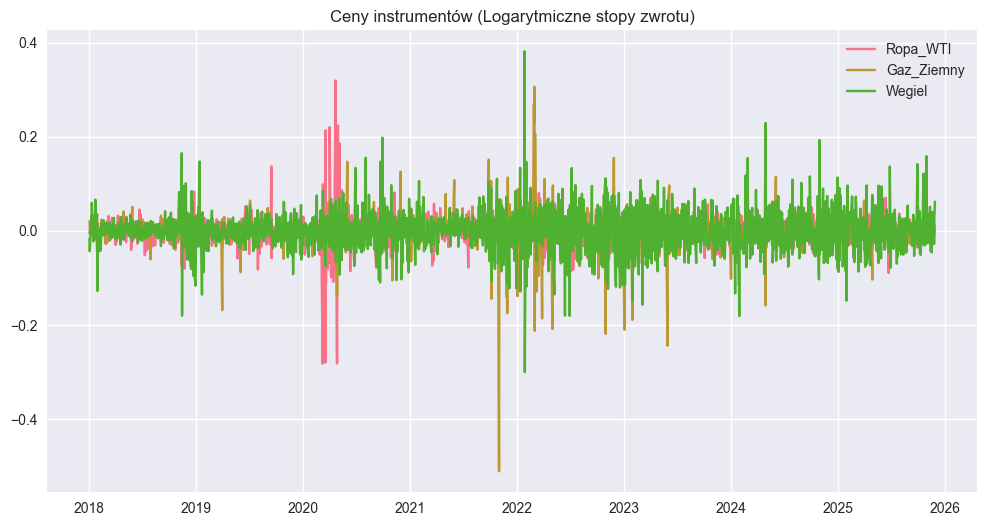

In [29]:
tickers = ['CL=F', 'NG=F', 'MTF=F'] 
names   = ['Ropa_WTI', 'Gaz_Ziemny', 'Wegiel']

dane = yf.download(
    tickers,
    start='2018-01-01',
    end='2025-12-01',
    auto_adjust=False,
    threads=False,
    timeout=20
)['Adj Close']

dane = dane.ffill().dropna()
    
# Logarytmiczne stopy zwrotu
log_returns = np.log(dane / dane.shift(1)).dropna()
log_returns.columns = names


# Wizualizacja cen (Niestacjonarne)
plt.figure(figsize=(12, 6))
for col in log_returns.columns:
    plt.plot(log_returns[col], label=col)
plt.title('Ceny instrumentów (Logarytmiczne stopy zwrotu)')
plt.legend()
plt.show()


ANALIZA EKSPLORACYJNA (EDA)

Statystyki opisowe log-zwrotów:
                mean       std       min       max      skew   kurtosis
Ropa_WTI    0.000287  0.029532 -0.282206  0.319634  0.034546  26.398513
Gaz_Ziemny  0.000002  0.029886 -0.511258  0.306201 -2.565599  66.549783
Wegiel      0.000213  0.042961 -0.300480  0.381727  0.241556   6.183989


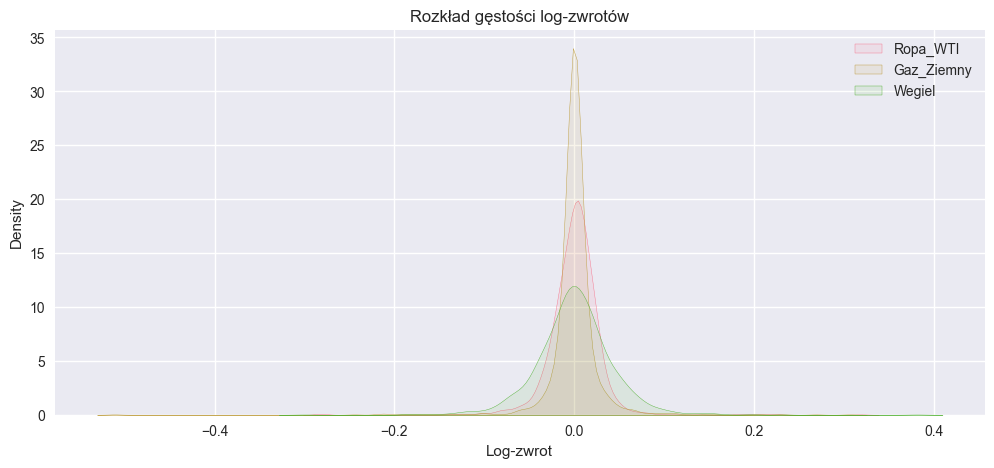

In [30]:
print("\nANALIZA EKSPLORACYJNA (EDA)")

# Statystyki opisowe
desc_stats = log_returns.describe().T
desc_stats['skew'] = log_returns.skew()
desc_stats['kurtosis'] = log_returns.kurtosis()
print("\nStatystyki opisowe log-zwrotów:")
print(desc_stats[['mean', 'std', 'min', 'max', 'skew', 'kurtosis']])

# Wykresy gęstości (Density Plots)
plt.figure(figsize=(12, 5))
for col in log_returns.columns:
    sns.kdeplot(log_returns[col], label=col, fill=True, alpha=0.1)
plt.title('Rozkład gęstości log-zwrotów')
plt.xlabel('Log-zwrot')
plt.legend()
plt.show()

In [31]:
print("\nTESTY STACJONARNOŚCI")
stationary = True
for col in log_returns.columns:
    res = adfuller(log_returns[col])
    print(f"Zmienna: {col:12} | ADF Stat: {res[0]:.4f} | p-value: {res[1]:.4f}")
    if res[1] > 0.05:
        print(f"UWAGA: Zmienna {col} może być niestacjonarna!")
        stationary = False

if stationary:
    print("-> Wszystkie zmienne są stacjonarne (I(0)). Można budować VAR.")
else:
    print("-> Wykryto niestacjonarność. Należy rozważyć inne przekształcenie.")


TESTY STACJONARNOŚCI
Zmienna: Ropa_WTI     | ADF Stat: -7.7564 | p-value: 0.0000
Zmienna: Gaz_Ziemny   | ADF Stat: -20.7677 | p-value: 0.0000
Zmienna: Wegiel       | ADF Stat: -20.8559 | p-value: 0.0000
-> Wszystkie zmienne są stacjonarne (I(0)). Można budować VAR.


In [35]:
from statsmodels.graphics.tsaplots import plot_acf

def dopasuj_var(data):
    """Dopasowuje model VAR i zwraca obiekt wyników oraz reszty."""
    model = VAR(data)
    lag_order_results = model.select_order(maxlags=10)
    print("\n--- Wybór rzędu opóźnień VAR ---")
    print(lag_order_results.summary())
    best_lag = lag_order_results.aic
    print(f"\nWybrany rząd opóźnień VAR (AIC): {best_lag}")
    
    var_result = model.fit(best_lag)
    residuals = var_result.resid
    return var_result, residuals, model

def diagnostyka_var_stability(var_result):
    """Sprawdza stabilność modelu VAR."""
    is_stable = var_result.is_stable()
    print(f"\n--- Diagnostyka VAR: Stabilność ---")
    print(f"Czy model VAR jest stabilny? {'TAK' if is_stable else 'NIE'}")
    if not is_stable:
        print("Ostrzeżenie: Pierwiastki wielomianu charakterystycznego leżą poza kołem jednostkowym.")
    return is_stable

def diagnostyka_var_whiteness(var_result, lags=10):
    """Test Portmanteau na autokorelację reszt wielowymiarowych."""
    print(f"\n--- Diagnostyka VAR: Test Portmanteau (Whiteness) ---")
    whiteness = var_result.test_whiteness(nlags=lags, signif=0.05, adjust=True)
    print(whiteness.summary())

def diagnostyka_univariate_reszty(std_resids, distribution='norm'):
    """
    Kompleksowa diagnostyka reszt standaryzowanych (po GARCH).
    Bada: Autokorelację (Ljung-Box), Efekty ARCH (McLeod-Li), Normalność (Jarque-Bera).
    """
    print(f"\n--- Diagnostyka reszt standaryzowanych (Univariate) ---")
    
    results = pd.DataFrame(index=std_resids.columns, 
                           columns=['LB_Q(10)_pval', 'ARCH_LM(10)_pval', 'JB_pval', 'Shapiro_pval'])
    
    for col in std_resids.columns:
        z = std_resids[col].dropna()
        z2 = z ** 2
        
        # 1. Test Ljung-Boxa na resztach (czy pozostała autokorelacja liniowa?)
        lb_res = acorr_ljungbox(z, lags=[10], return_df=True)
        lb_pval = lb_res['lb_pvalue'].iloc[0]
        
        # 2. Test McLeoda-Li (Ljung-Box na kwadratach) - czy pozostał efekt ARCH?
        arch_lb_res = acorr_ljungbox(z2, lags=[10], return_df=True)
        arch_pval = arch_lb_res['lb_pvalue'].iloc[0]
        
        # 3. Test Jarque-Bera (Normalność)
        jb_stat, jb_pval = stats.jarque_bera(z)
        
        # 4. Test Shapiro-Wilka (Normalność - lepszy dla mniejszych prób, ale ok dla n<5000)
        # Dla dużych prób p-value często dąży do 0 nawet przy małych odchyleniach.
        sh_stat, sh_pval = stats.shapiro(z) if len(z) < 5000 else (0, 0)

        results.loc[col] = [lb_pval, arch_pval, jb_pval, sh_pval]

        # Wizualizacja dla każdego aktywa
        fig, axes = plt.subplots(2, 2, figsize=(10, 7))
        fig.suptitle(f'Diagnostyka reszt: {col}', fontsize=12)
        
        # Wykres reszt
        axes[0, 0].plot(z, alpha=0.7)
        axes[0, 0].set_title('Reszty standaryzowane')
        
        # Histogram vs Rozkład Normalny
        axes[0, 1].hist(z, bins=30, density=True, alpha=0.6, color='gray')
        xmin, xmax = axes[0, 1].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, 0, 1)
        axes[0, 1].plot(x, p, 'r', linewidth=2)
        axes[0, 1].set_title('Histogram vs N(0,1)')
        
        # ACF reszt kwadratowych (czy wariancja jest dobrze modelowana?)
        plot_acf(z2, ax=axes[1, 0], lags=20, title='ACF kwadratów reszt', zero=False)

        
        # QQ-Plot
        stats.probplot(z, dist=distribution, plot=axes[1, 1])
        axes[1, 1].set_title(f'QQ-Plot ({distribution})')
        
        plt.tight_layout()
        plt.show()

    print(results)
    return results

def dopasuj_univariate_garch(residuals, vol_model='Garch', dist='Normal', p=1, q=1):
    """
    Dopasowuje model GARCH/EGARCH/GJR-GARCH do każdej serii reszt.
    
    Args:
        vol_model: 'Garch', 'EGARCH', 'GJR-GARCH' (w arch pakiecie GJR to 'Garch' z o=1)
        dist: 'Normal' lub 't' (t-Student)
    """
    std_resids = pd.DataFrame(index=residuals.index, columns=residuals.columns)
    cond_vol = pd.DataFrame(index=residuals.index, columns=residuals.columns)
    models = {}

    # Mapowanie nazw dla biblioteki arch
    arch_dist = 'normal' if dist == 'Normal' else 't'
    
    print(f"\n--- Dopasowanie jednowymiarowe: {vol_model} z rozkładem {dist} ---")
    
    for col in residuals.columns:
        series = residuals[col]
        
        # Konfiguracja modelu
        if vol_model == 'GJR-GARCH':
            # GJR w arch to GARCH z parametrem 'o' (asymetria)
            am = arch_model(series, vol='Garch', p=p, o=1, q=q, dist=arch_dist, rescale=False)
        elif vol_model == 'EGARCH':
            am = arch_model(series, vol='EGARCH', p=p, q=q, dist=arch_dist, rescale=False)
        else: # Standard GARCH
            am = arch_model(series, vol='Garch', p=p, q=q, dist=arch_dist, rescale=False)
            
        res = am.fit(disp='off')
        
        cond_vol[col] = res.conditional_volatility
        std_resids[col] = res.std_resid
        models[col] = res
        print(res.params)
        # Diagnostyka
        print(f"Instrument: {col} | AIC: {res.aic:.2f} | Parametry: {len(res.params)}")

    return std_resids, cond_vol, models

# --- ETAP 3: MODEL DCC (MULTIVARIATE) ---
class DCC_Model:
    """Prosta implementacja estymatora DCC (Engle 2002) przy użyciu numpy/scipy."""
    
    def __init__(self, std_resids):
        self.std_resids = std_resids.values
        self.T, self.N = self.std_resids.shape
        # Bezwarunkowa korelacja (Targeting)
        self.Q_bar = np.cov(self.std_resids.T)
    
    def dcc_likelihood(self, params):
        a, b = params
        Q_t = self.Q_bar.copy()
        log_lik = 0.0
        
        # Q_bar * (1 - a - b)
        intercept = self.Q_bar * (1 - a - b)
        
        for t in range(self.T):
            u_t = self.std_resids[t, :][:, None] # wektor kolumnowy (N, 1)
            
            # Ewolucja Q_t: Q_t = (1-a-b)Q_bar + a * u_{t-1}u_{t-1}' + b * Q_{t-1}
            # Obliczenie korelacji R_t z Q_t
            # R_t = diag(Q_t)^(-1/2) * Q_t * diag(Q_t)^(-1/2)
            d_inv = np.diag(1.0 / np.sqrt(np.diag(Q_t)))
            R_t = d_inv @ Q_t @ d_inv
            
            # Sprawdzenie czy R_t jest dodatnio określona (numeryka)
            try:
                R_inv = np.linalg.inv(R_t)
                _, logdet = np.linalg.slogdet(R_t)
            except:
                return 1e10 # Kara za błąd numeryczny
                
            # Log-wiarygodność dla części korelacyjnej (zakładając normalność dla uproszczenia w kroku 2)
            # LL_c = -0.5 * (log|R| + u'R^{-1}u - u'u)
            part1 = logdet
            part2 = (u_t.T @ R_inv @ u_t).item()
            part3 = (u_t.T @ u_t).item()
            
            log_lik += 0.5 * (part1 + part2 - part3)
            
            # Aktualizacja Q_t na następny krok
            Q_t = intercept + a * (u_t @ u_t.T) + b * Q_t
            
        return log_lik

    def fit(self):
        # Ograniczenia: a > 0, b > 0, a + b < 1
        cons = ({'type': 'ineq', 'fun': lambda x: 1 - x[0] - x[1]},
                {'type': 'ineq', 'fun': lambda x: x[0]},
                {'type': 'ineq', 'fun': lambda x: x[1]})
        
        # Punkt startowy
        initial_guess = [0.05, 0.90]
        
        print("\nOptymalizacja parametrów DCC...")
        result = minimize(self.dcc_likelihood, initial_guess, constraints=cons, method='SLSQP')
        
        self.a, self.b = result.x
        print(f"Parametry DCC: alpha={self.a:.4f}, beta={self.b:.4f} (Suma: {self.a+self.b:.4f})")
        return result

    def get_conditional_correlations(self):
        a, b = self.a, self.b
        Q_t = self.Q_bar.copy()
        correlations = np.zeros((self.T, self.N, self.N))
        
        for t in range(self.T):
            d_inv = np.diag(1.0 / np.sqrt(np.diag(Q_t)))
            R_t = d_inv @ Q_t @ d_inv
            correlations[t] = R_t
            
            u_t = self.std_resids[t, :][:, None]
            Q_t = self.Q_bar * (1 - a - b) + a * (u_t @ u_t.T) + b * Q_t
            
        return correlations


--- Wybór rzędu opóźnień VAR ---
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -20.37     -20.37*   1.417e-09      -20.37
1       -20.38      -20.35   1.404e-09     -20.37*
2       -20.39      -20.33   1.402e-09      -20.36
3      -20.39*      -20.31  1.396e-09*      -20.36
4       -20.39      -20.28   1.397e-09      -20.35
5       -20.39      -20.25   1.401e-09      -20.34
6       -20.38      -20.22   1.407e-09      -20.32
7       -20.39      -20.20   1.402e-09      -20.32
8       -20.38      -20.17   1.408e-09      -20.30
9       -20.38      -20.14   1.409e-09      -20.29
10      -20.37      -20.11   1.418e-09      -20.28
--------------------------------------------------

Wybrany rząd opóźnień VAR (AIC): 3

--- Diagnostyka VAR: Stabilność ---
Czy model VAR jest stabilny? TAK

--- Dopasowanie jednowymiarowe: Garch z rozkładem Normal ---
mu          0.000396
omega       

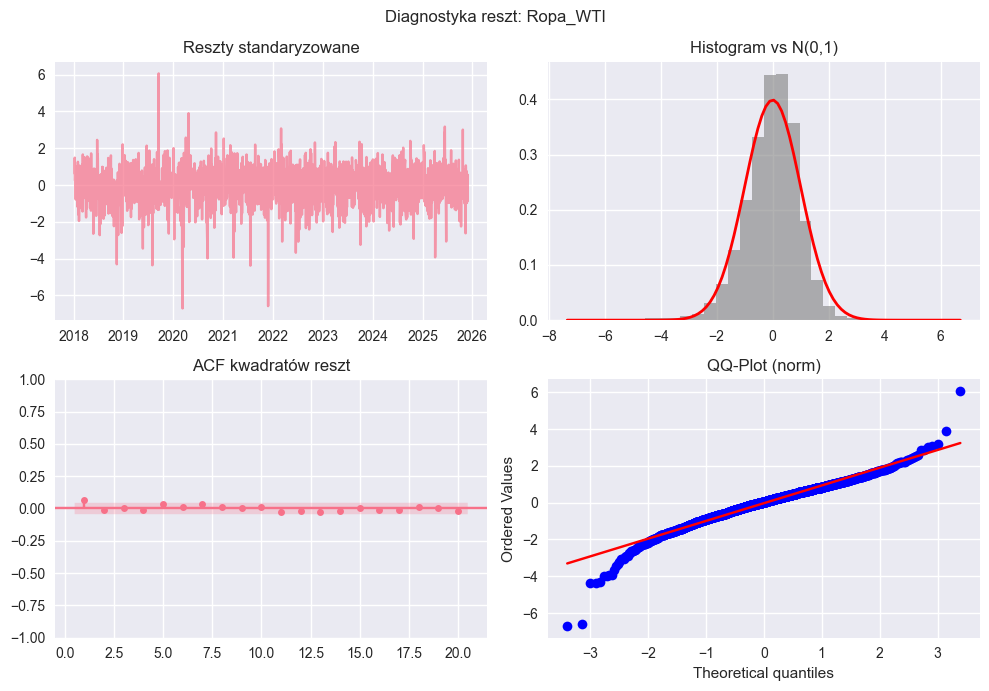

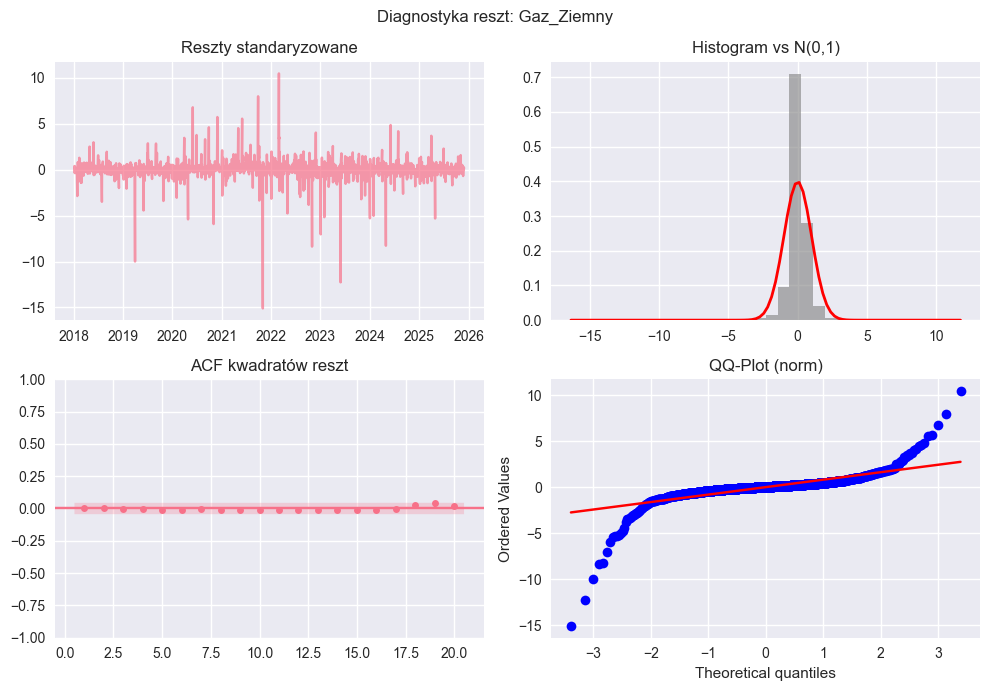

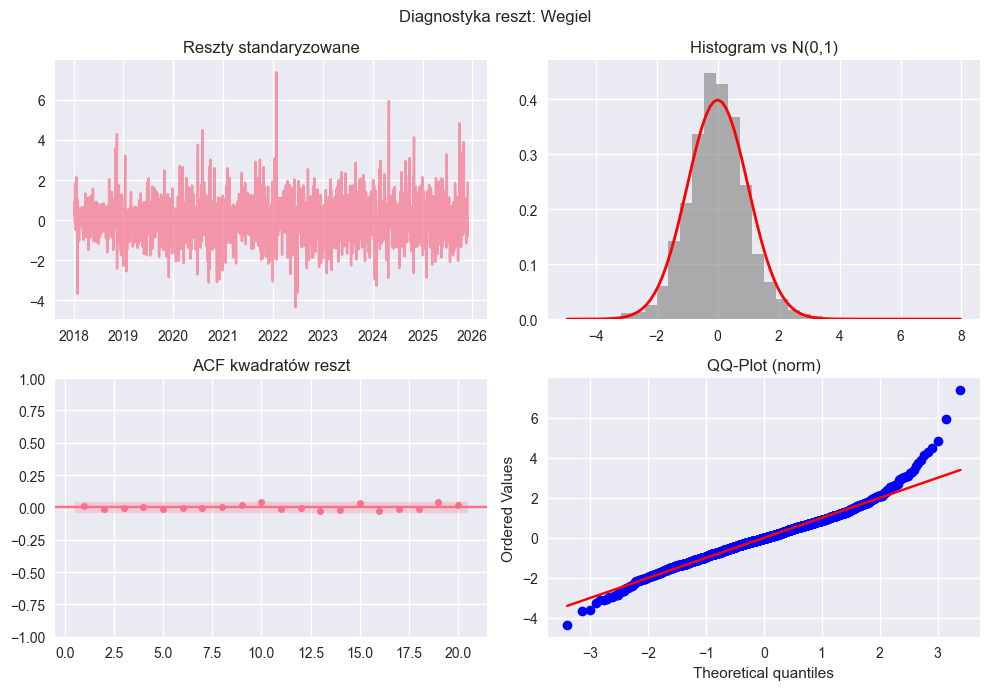

           LB_Q(10)_pval ARCH_LM(10)_pval JB_pval Shapiro_pval
Ropa_WTI        0.782465          0.16455     0.0          0.0
Gaz_Ziemny      0.630553         0.998827     0.0          0.0
Wegiel          0.205499         0.881344     0.0          0.0


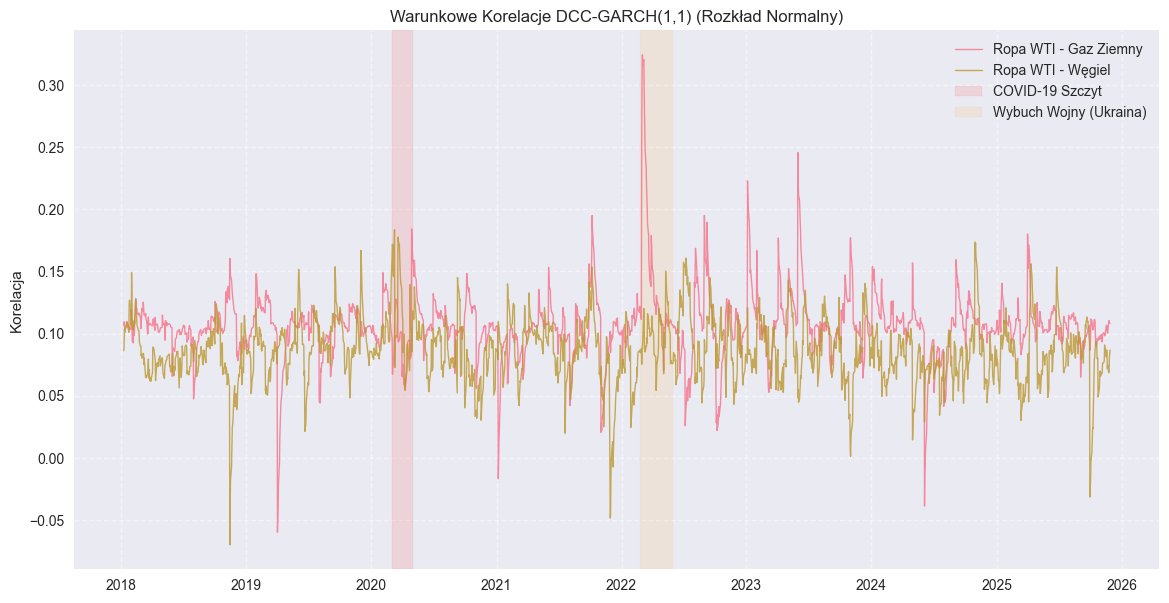

In [36]:
# 2. VAR (Reszty)
# dopasuj_var zwraca: (var_result, residuals, model)
var_result, var_residuals, var_model = dopasuj_var(log_returns)
diagnostyka_var_stability(var_result)

# 3. Jednowymiarowy GARCH (Część A: Tylko GARCH + Rozkład Normalny)
# W pełnym badaniu można tutaj podmienić 'Garch' na 'EGARCH' lub 'GJR-GARCH' oraz dist na 't'
std_resid, cond_vol, univariate_models = dopasuj_univariate_garch(
    var_residuals, 
    vol_model='Garch', 
    dist='Normal'
)

# Diagnostyka reszt standaryzowanych (Test Jarque-Bera na normalność)
print("\nTest Jarque-Bera dla reszt standaryzowanych (p-value):")
for col in std_resid.columns:
    stat, pval = stats.jarque_bera(std_resid[col])
    print(f"{col}: {pval:.4f} (H0: Normalność)")


# 4. Model DCC (Rozkład wielowymiarowy normalny - estymacja QMLE)
dcc = DCC_Model(std_resid)
dcc.fit()
dynamic_corrs = dcc.get_conditional_correlations()
diagnostyka_univariate_reszty(std_resid, distribution='norm')
# --- WIZUALIZACJA ---
dates = std_resid.index
    
# Wyciągnięcie korelacji par: Ropa vs Gaz, Ropa vs Węgiel
# Indeksy: 0: Ropa, 1: Gaz, 2: Węgiel
rho_ropa_gaz = dynamic_corrs[:, 0, 1]
rho_ropa_wegiel = dynamic_corrs[:, 0, 2]
rho_gaz_wegiel = dynamic_corrs[:, 1, 2]

plt.figure(figsize=(14, 7))
plt.plot(dates, rho_ropa_gaz, label='Ropa WTI - Gaz Ziemny', alpha=0.8, linewidth=1)
plt.plot(dates, rho_ropa_wegiel, label='Ropa WTI - Węgiel', alpha=0.8, linewidth=1)

# Zaznaczenie okresów kryzysowych
# COVID-19 (Marzec 2020)
plt.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-05-01'), color='red', alpha=0.1, label='COVID-19 Szczyt')
# Wojna na Ukrainie (Luty 2022)
plt.axvspan(pd.Timestamp('2022-02-24'), pd.Timestamp('2022-06-01'), color='orange', alpha=0.1, label='Wybuch Wojny (Ukraina)')

plt.title('Warunkowe Korelacje DCC-GARCH(1,1) (Rozkład Normalny)')
plt.ylabel('Korelacja')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()